# 13 Extracting Interface Points and Orientations from Geological Cross Sections

Geologists often work with geological maps. In addition, geological cross sections are provided with these maps to illustrate an image of the subsurface. The displayed lithological boundaries and structures can be used for geological modeling. Therefore, the interfaces and orientations of the layers have to be extracted.

<img src="../images/tutorial13_cover.png">

The data used for GemGIS is obtained from [OpenDataNRW](#https://www.opengeodata.nrw.de/produkte/geologie/geologie/GK/ISGK100/GK100analog/). It will be used under Datenlizenz Deutschland – Namensnennung – Version 2.0 (https://www.govdata.de/dl-de/by-2-0) with © Geowissenschaftliche Daten: Analoges Kartenwerk der Geologischen Karte von Nordrhein-Westfalen 1:100.000 (2020).

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import gemgis as gg

file_path ='data/13_extracting_interfaces_orientations_from_cross_sections/'

In [2]:
gg.download_gemgis_data.download_tutorial_data(filename="13_extracting_interfaces_orientations_from_cross_sections.zip", dirpath=file_path)

## Extracting Interfaces from Cross Sections

Interfaces can be extracted from georeferenced maps and cross sections by digitizing the layer data as shape files. The following illustrates the data preparation steps and the extraction of coordinates in GemGIS.

### Data Preparation 

For the extraction of interfaces and orientation, the same principles as for maps are used. This is, that the interfaces and orientations are digitized in a GIS environment using shape files to store the layer data. The cross section used here is obtained from [OpenGeoData.NRW](#https://www.opengeodata.nrw.de/produkte/geologie/geologie/GK/ISGK100/GK100analog/). The cross section is part of the 'Analoges Kartenwerk der Geologischen Karte von Nordrhein Westfalen 1:100 000' and in particular of map sheet GK100-C4706-Düsseldorf-Essen. The data is used under Datenlizenz Deutschland Namensnennung 2.0 (https://www.govdata.de/dl-de/by-2-0).

<img src="../images/tutorial13_maps.png">

<img src="../images/tutorial13_cross_section.png">

### Georeference Cross Section

The first step is to georeference the cross section. A tutorial on how to georeference maps is provided on this documentation page. For the georeferencing here, we are taking four points on the two axes of the cross section. It is important that the coordinates on the left side mark the origin and are defined by X = 0. The coordinates will be:
 
* 0,0
* 0,-4500
* 52000, 0
* 52000, -4500

NB: Ideally, you would look up the exact length of the section which is 51819.98 m but 52000 m is close enough for this demonstration. 

<img src="../images/tutorial13_georeferencing.png">

### Digitizing the layer data

In order to digitize the layer data, a new line shape file is created and the layer boundaries are digitized. The image below shows some of the digitized layers in red. This can now be read in as GeoDataFrames for further processing with GemGIS.

<img src="../images/tutorial13_interfaces.png">

### Loading the data

Next to the digitized interfaces, we also need to load the trace of the profile. This is shown in one of the figures above and was also saved as shape file for further processing. In addition, we are loading the raster of the cross section and the geological map for visualization purposes.

In [3]:
import geopandas as gpd
import rasterio

interfaces = gpd.read_file(file_path + 'interfaces.shp')

section = rasterio.open(file_path + 'cross_section.tif')

gmap = rasterio.open(file_path + 'C4706_Duesseldorf_Essen_2Aufl_prs_utm32n.jpg')

trace = gpd.read_file(file_path + 'trace.shp')

In [4]:
interfaces.head()

,id,formation,geometry
0,None,Massenkalk,"LINESTRING (36281.025 -515.603, 36198.287 -606..."
1,None,doV,"LINESTRING (36262.451 161.499, 36221.926 -3.97..."
2,None,t,"LINESTRING (-11.512 -82.198, 1761.939 -48.737,..."
3,None,kr,"LINESTRING (4.757 -417.917, 561.958 -449.859, ..."
4,None,z,"LINESTRING (8.306 -492.448, 711.018 -478.251)"


### Plotting the Input data

The raster containing the image of the cross section and the interfaces can be plotted together.

<AxesSubplot: >

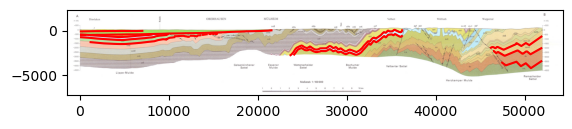

In [5]:
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image

fig, ax = plt.subplots(1,1)
ax.imshow(reshape_as_image(section.read()), extent=[section.bounds[0],section.bounds[2],section.bounds[1],section.bounds[3]])
interfaces.plot(ax=ax, aspect='equal', color='red')

The trace of the profile can also be plotted. The GeoDataFrame has to be converted to the matching Coordinate Reference System before plotting. In addition, the geological map is shown to visualize the location of the section on the map. 

In [6]:
trace

,id,geometry
0,None,"LINESTRING (32344311.102 5718801.515, 32349696..."


In [7]:
trace.length

0   51819.98
dtype: float64

<AxesSubplot: >

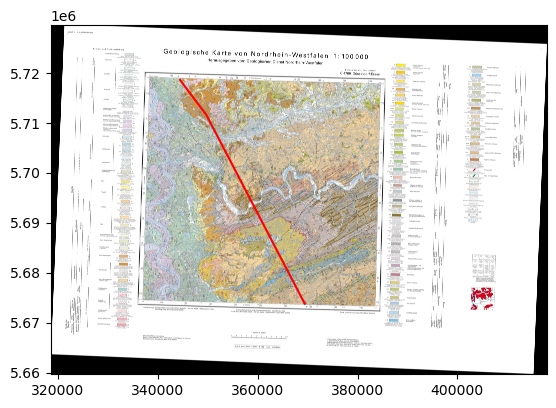

In [8]:
fig, ax = plt.subplots(1,1)

ax.imshow(reshape_as_image(gmap.read()), extent=[gmap.bounds[0],gmap.bounds[2],gmap.bounds[1],gmap.bounds[3]])
trace.to_crs('EPSG:25832').plot(ax=ax, aspect='equal', color='red')

### Extracting the real world coordinates from the cross section

The extraction of the real world coordinates is performed in several steps:

* Extracting the striking angle of the profile
* Calculating real word coordinates for one LineString on the Cross Section
* Calculating real word coordinates for LineStrings on the Cross Section
* Extracting Coordinates from the cross section
* Extracting XYZ from the cross section


### Extracting Striking angle of the profile

Here, the strike angles of a LineString with multiple vertices is shown. For straight profiles with only two vertices, the function ``calculate_strike_direction_straight_linestring(..)`` can be used. The calculation shows that the first part of the profile is striking towards 143 degrees to the SE and the second part with 152 degrees to the SE. This can be confirmed when looking at the map.

In [9]:
angles = gg.vector.calculate_strike_direction_bent_linestring(linestring=trace.loc[0].geometry)
angles

[142.97370864998288, 152.47884465731576]

### Calculating real word coordinates for one LineString on the Cross Section

The next step is to calculate the real world coordinates of one LineString located on the cross section. This function uses the previously calculated striking angle of each section of the line string and the distance of each digitized vertex to the origin to calculate the real world coordinates. This function is the extension of ``calculate_coordinates_for_point_on_cross_section(..)``. The results are stored as Shapely Point objects.

In [10]:
points = gg.vector.calculate_coordinates_for_linestring_on_cross_sections(linestring=trace.loc[0].geometry,
                                                                          interfaces=interfaces.loc[0].geometry)
points[:5]

[<POINT (32362328.62 5687417.302)>,
 <POINT (32362290.388 5687490.677)>,
 <POINT (32362256.058 5687556.565)>,
 <POINT (32362217.827 5687629.941)>,
 <POINT (32362172.574 5687716.793)>]

### Plotting the points

The points can be converted to a GeoDataFrame and can be plotted. It can be seen that the extracted points are located exactly on the profile line/trace.

In [11]:
points_gdf = gpd.GeoDataFrame(geometry=points)
points_gdf.head()

,geometry
0,POINT (32362328.620 5687417.302)
1,POINT (32362290.388 5687490.677)
2,POINT (32362256.058 5687556.565)
3,POINT (32362217.827 5687629.941)
4,POINT (32362172.574 5687716.793)


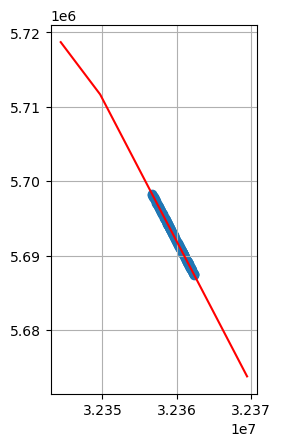

In [12]:
fig, ax = plt.subplots(1,1)

trace.plot(ax=ax, aspect='equal', color='red')

points_gdf.plot(ax=ax,aspect='equal')
plt.grid()

### Calculating real word coordinates for LineStrings on the Cross Section

The previous function can be extended to multiple LineStrings by providing a list of LineStrings.

In [13]:
points = gg.vector.calculate_coordinates_for_linestrings_on_cross_sections(linestring=trace.loc[0].geometry,
                                                                           linestring_interfaces_list=interfaces.geometry.to_list())
points[:5]

[<POINT (32362328.62 5687417.302)>,
 <POINT (32362290.388 5687490.677)>,
 <POINT (32362256.058 5687556.565)>,
 <POINT (32362217.827 5687629.941)>,
 <POINT (32362172.574 5687716.793)>]

### Plotting the points

The points can be converted to a GeoDataFrame and plotted. It can be seen that the extracted points are located exactly on the profile line/trace.

In [14]:
points_gdf = gpd.GeoDataFrame(geometry=points)
points_gdf.head()

,geometry
0,POINT (32362328.620 5687417.302)
1,POINT (32362290.388 5687490.677)
2,POINT (32362256.058 5687556.565)
3,POINT (32362217.827 5687629.941)
4,POINT (32362172.574 5687716.793)


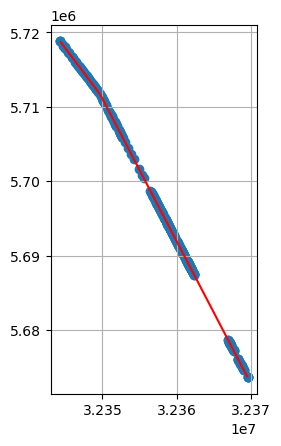

In [15]:
fig, ax = plt.subplots(1,1)

trace.plot(ax=ax, aspect='equal', color='red')

points_gdf.plot(ax=ax,aspect='equal')
plt.grid()

### Extracting Coordinates from the cross section

The next step is to not only extract the points in X and Y direction but also the Z component and any additional column in the original interfaces GeoDataFrame.

In [16]:
gdf = gg.vector.extract_interfaces_coordinates_from_cross_section(linestring=trace.loc[0].geometry,
                                                                  interfaces_gdf=interfaces)
gdf

,formation,geometry,X,Y,Z
0,Massenkalk,POINT (32362328.620 5687417.302),32362328.62,5687417.30,-515.60
1,Massenkalk,POINT (32362290.388 5687490.677),32362290.39,5687490.68,-606.78
2,Massenkalk,POINT (32362256.058 5687556.565),32362256.06,5687556.57,-667.57
3,Massenkalk,POINT (32362217.827 5687629.941),32362217.83,5687629.94,-684.46
4,Massenkalk,POINT (32362172.574 5687716.793),32362172.57,5687716.79,-654.06
...,...,...,...,...,...
409,dem-eH,POINT (32367071.249 5678315.003),32367071.25,5678315.00,-1871.63
410,dem-eH,POINT (32367025.837 5678402.159),32367025.84,5678402.16,-1836.95
411,dem-eH,POINT (32366980.426 5678489.316),32366980.43,5678489.32,-1842.73
412,dem-eH,POINT (32366918.986 5678607.233),32366918.99,5678607.23,-1912.10


### Extracting XYZ from the cross section

All the above steps are collected in a final function to extract the real world coordinates from the cross section. An additional column for the name of the profile needs to be provided so that coordinates for multiple profiles can be calculated.

In [17]:
trace['name'] = 'Profile1'
interfaces['name'] = 'Profile1'

In [18]:
gdf = gg.vector.extract_xyz_from_cross_sections(profile_gdf=trace,
                                                interfaces_gdf=interfaces)
gdf

,formation,name,geometry,X,Y,Z
0,Massenkalk,Profile1,POINT (32362328.620 5687417.302),32362328.62,5687417.30,-515.60
1,Massenkalk,Profile1,POINT (32362290.388 5687490.677),32362290.39,5687490.68,-606.78
2,Massenkalk,Profile1,POINT (32362256.058 5687556.565),32362256.06,5687556.57,-667.57
3,Massenkalk,Profile1,POINT (32362217.827 5687629.941),32362217.83,5687629.94,-684.46
4,Massenkalk,Profile1,POINT (32362172.574 5687716.793),32362172.57,5687716.79,-654.06
...,...,...,...,...,...,...
409,dem-eH,Profile1,POINT (32367071.249 5678315.003),32367071.25,5678315.00,-1871.63
410,dem-eH,Profile1,POINT (32367025.837 5678402.159),32367025.84,5678402.16,-1836.95
411,dem-eH,Profile1,POINT (32366980.426 5678489.316),32366980.43,5678489.32,-1842.73
412,dem-eH,Profile1,POINT (32366918.986 5678607.233),32366918.99,5678607.23,-1912.10


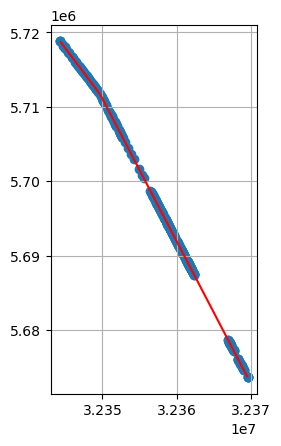

In [19]:
fig, ax = plt.subplots(1,1)

trace.plot(ax=ax, aspect='equal', color='red')

gdf.plot(ax=ax,aspect='equal')
plt.grid()

## Extracting Orientations from Cross Sections

Orientations can also be extracted from cross sections using GemGIS. However, be aware that the azimuth or dipping orientation will always be the apparent angle in line with the strike of the profile. 


### Data Preparation

The same georeferenced section as before is needed to prepare the data. 

### Digitizing the Data

Orientations display the dipping/slope of a layer. For GemGIS, a straight line consisting of a start and end point needs to be digitized following the dipping of the layers as shown below. 
<img src="../images/tutorial13_orientations.png">


### Loading the data

Next to the digitized interfaces, we also need to load the trace of the profile. This is shown in one of the figures above and was also saved as shape file for further processing. In addition, we are loading the raster of the cross section and the geological map for visualization purposes.

In [20]:
import geopandas as gpd
import rasterio
import gemgis as gg

orientations = gpd.read_file(file_path + 'orientations.shp')

section = rasterio.open(file_path + 'cross_section.tif')

gmap = rasterio.open(file_path + 'C4706_Duesseldorf_Essen_2Aufl_prs_utm32n.jpg')

trace = gpd.read_file(file_path + 'trace.shp')

In [21]:
orientations.head()

,id,formation,geometry
0,None,cnS,"LINESTRING (8750.658 -3025.432, 5916.398 -3316..."
1,None,cwB,"LINESTRING (8055.070 -1862.659, 5490.740 -2111..."
2,None,cwE,"LINESTRING (8044.688 -1239.745, 5366.157 -1499..."
3,None,kr,"LINESTRING (6726.187 -398.810, 3632.379 -450.720)"
4,None,Massenkalk,"LINESTRING (32353.917 -1613.493, 31502.601 -25..."


### Plotting the Input data

The raster containing the image of the cross section and the interfaces can be plotted together.

<AxesSubplot: >

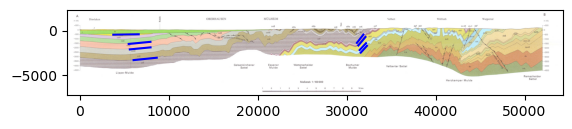

In [22]:
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image

fig, ax = plt.subplots(1,1)
ax.imshow(reshape_as_image(section.read()), extent=[section.bounds[0],section.bounds[2],section.bounds[1],section.bounds[3]])
orientations.plot(ax=ax, aspect='equal', color='blue')

The trace of the profile can also be plotted. The GeoDataFrame has to be converted to the matching Coordinate Reference System before plotting. In addition, the geological map is shown to visualize the location of the section on the map. 

In [23]:
trace

,id,geometry
0,None,"LINESTRING (32344311.102 5718801.515, 32349696..."


In [24]:
trace.length

0   51819.98
dtype: float64

<AxesSubplot: >

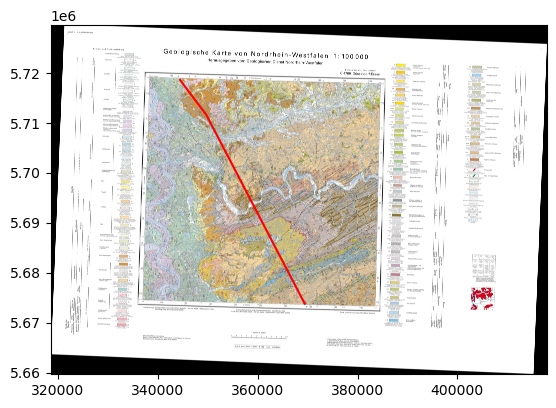

In [25]:
fig, ax = plt.subplots(1,1)

ax.imshow(reshape_as_image(gmap.read()), extent=[gmap.bounds[0],gmap.bounds[2],gmap.bounds[1],gmap.bounds[3]])
trace.to_crs('EPSG:25832').plot(ax=ax, aspect='equal', color='red')

### Extracting the real world coordinates from the cross section

The extraction of the real world coordinates is performed in several steps:

* Extracting the striking angle of the profile
* Calculating the midpoint of one LineString
* Calculating the midpoints of LineStrings
* Calculating orientation from cross section
* Calculating orientations from cross section

### Extracting Striking angle of the profile

Here, the strike angles of a LineString with multiple vertices is shown. For straight profiles with only two vertices, the function ``calculate_strike_direction_straight_linestring(..)`` can be used. The calculation shows that the first part of the profile is striking towards 143 degrees to the SE and the second part with 152 degrees to the SE. This can be confirmed when looking at the map.

In [26]:
angles = gg.vector.calculate_strike_direction_bent_linestring(linestring=trace.loc[0].geometry)
angles

[142.97370864998288, 152.47884465731576]

### Calculating the midpoint of one LineString

The location for the orientation after its extraction will be the midpoint of the digitized LineString.

In [27]:
orientations.loc[0].geometry.wkt

'LINESTRING (8750.657889753686 -3025.432084887312, 5916.398060484471 -3316.125400709796)'

In [28]:
midpoint = gg.vector.calculate_midpoint_linestring(linestring=orientations.loc[0].geometry)
midpoint.wkt

'POINT (7333.527975119078 -3170.778742798554)'

### Calculating the midpoints of LineStrings.

The previous function can be extended to work for a list of LineStrings or a GeoDataFrame containing LineStrings. In this case, the orientations GeoDataFrame.

In [29]:
midpoints = gg.vector.calculate_midpoints_linestrings(linestring_gdf=orientations)
midpoints

[<POINT (7333.528 -3170.779)>,
 <POINT (6772.905 -1987.242)>,
 <POINT (6705.423 -1369.518)>,
 <POINT (5179.283 -424.765)>,
 <POINT (31928.259 -2080.679)>,
 <POINT (31814.058 -1789.985)>,
 <POINT (31710.239 -1182.644)>,
 <POINT (31512.983 -902.333)>]

### Calculating Orientation from Cross Section

In order to calculate the orientation from the cross section, the real world coordinates of the midpoint of the respective LineString and its dip will be calculated. In addition, the strike of the profile will be calculated from which the azimuth of the orientation value will be derived from. As we have a bent cross section, ``calculate_orientation_from_cross_section(..)`` is skipped and ``calculate_orientation_from_bent_cross_section(..)`` will be used right away. The resulting list contains the midpoint coordinates, the depth, dip, azimuth and polarity of the orientation value.

In [30]:
orientation = gg.vector.calculate_orientation_from_bent_cross_section(profile_linestring=trace.loc[0].geometry,
                                                                      orientation_linestring=orientations.loc[0].geometry)
orientation

[<POINT (32348727.216 5712946.725)>,
 -3170.778742798554,
 5.856013585428961,
 322.9737086499829,
 1]

### Calculating Orientations from Cross Sections

The next step is to calculate the orientations of multiple LineStrings from a cross section. 

In [31]:
orientation_gdf = gg.vector.calculate_orientations_from_cross_section(profile_linestring=trace.loc[0].geometry,
                                                                      orientation_linestrings=orientations)
orientation_gdf

,X,Y,Z,dip,azimuth,polarity,geometry,id,formation
0,32348727.22,5712946.72,-3170.78,5.86,322.97,1.00,POINT (32348727.216 5712946.725),None,cnS
1,32348389.62,5713394.30,-1987.24,5.55,322.97,1.00,POINT (32348389.620 5713394.303),None,cwB
2,32348348.98,5713448.18,-1369.52,5.53,322.97,1.00,POINT (32348348.983 5713448.178),None,cwE
3,32347429.97,5714666.59,-424.77,0.96,322.97,1.00,POINT (32347429.970 5714666.586),None,kr
4,32360317.31,5691277.51,-2080.68,47.66,332.48,1.00,POINT (32360317.311 5691277.510),None,Massenkalk
5,32360264.54,5691378.79,-1789.99,46.97,332.48,1.00,POINT (32360264.541 5691378.788),None,doV
6,32360216.57,5691470.86,-1182.64,49.83,332.48,1.00,POINT (32360216.569 5691470.859),None,ct-vk
7,32360125.42,5691645.79,-902.33,51.87,332.48,1.00,POINT (32360125.421 5691645.794),None,cv-nH


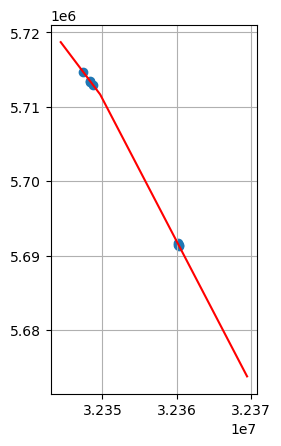

In [32]:
fig, ax = plt.subplots(1,1)

trace.plot(ax=ax, aspect='equal', color='red')

orientation_gdf.plot(ax=ax,aspect='equal')
plt.grid()

### Extracting Orientations from Cross Sections

The above functions are collected in the function ``extract_orientations_from_cross_section(..)`` to also work for multiple profiles. Therefore, the profile name needs to be provided as well.

In [33]:
trace['name'] = 'Profile1'
orientations['name'] = 'Profile1'

In [34]:
orientation_gdf = gg.vector.extract_orientations_from_cross_sections(profile_gdf=trace,
                                                                     orientations_gdf=orientations)
orientation_gdf

,X,Y,Z,dip,azimuth,polarity,geometry,id,formation,name
0,32348727.22,5712946.72,-3170.78,5.86,322.97,1.00,POINT (32348727.216 5712946.725),None,cnS,Profile1
1,32348389.62,5713394.30,-1987.24,5.55,322.97,1.00,POINT (32348389.620 5713394.303),None,cwB,Profile1
2,32348348.98,5713448.18,-1369.52,5.53,322.97,1.00,POINT (32348348.983 5713448.178),None,cwE,Profile1
3,32347429.97,5714666.59,-424.77,0.96,322.97,1.00,POINT (32347429.970 5714666.586),None,kr,Profile1
4,32360317.31,5691277.51,-2080.68,47.66,332.48,1.00,POINT (32360317.311 5691277.510),None,Massenkalk,Profile1
5,32360264.54,5691378.79,-1789.99,46.97,332.48,1.00,POINT (32360264.541 5691378.788),None,doV,Profile1
6,32360216.57,5691470.86,-1182.64,49.83,332.48,1.00,POINT (32360216.569 5691470.859),None,ct-vk,Profile1
7,32360125.42,5691645.79,-902.33,51.87,332.48,1.00,POINT (32360125.421 5691645.794),None,cv-nH,Profile1


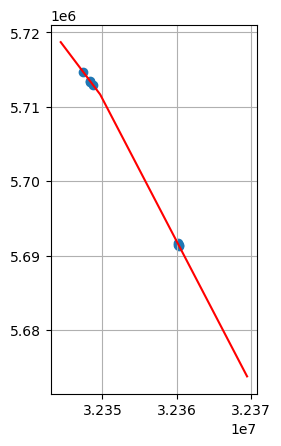

In [35]:
fig, ax = plt.subplots(1,1)

trace.plot(ax=ax, aspect='equal', color='red')

orientation_gdf.plot(ax=ax,aspect='equal')
plt.grid()

## Plotting the data with PyVista

The extracted point and the cross sections could now be plotted in PyVista according to Tutorials 10 and 12.